# Coverage Algorithm

### Geração do Mapa

In [231]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import networkx as nx

MAX_SIZE = 500

def draw_line(image, pt1, pt2, color=(0, 0, 0), thickness=2):
    cv2.line(image, tuple(pt1), tuple(pt2), color, thickness)

def draw_bottom_lines(image, vertex):
    line = []
    collision_index = None
    bottom_seq = range(vertex[1] + 2, MAX_SIZE, 1)

    for i in bottom_seq:
        line_point = [vertex[0], i]
        line.append(line_point)
    
        # Check for collision
        if (image[i, vertex[0]].all() == 0):
            collision_index = i

            if i != bottom_seq[0]:
                return [vertex[0], collision_index - 1]
            break

    if collision_index is None:
        return [vertex[0], MAX_SIZE]
    return None

def draw_top_lines(image, vertex):
    line = []
    collision_index = None

    top_seq = range(vertex[1] - 2, 0, -1)

    for i in top_seq:
        line_point = [vertex[0], i]
        line.append(line_point)
    
        # Check for collision
        if (image[i, vertex[0]].all() == 0):
            collision_index = i

            if i != top_seq[0]:
                return [vertex[0], collision_index + 1]
            break

    if collision_index is None:
        return [vertex[0], 0]
    return None

height, width = MAX_SIZE, MAX_SIZE
image = np.ones((height, width, 3), dtype=np.uint8) * 255

vertices = [[180, 230], [270, 180], [300, 200], [250, 260], [350, 300], [200, 280]]
border = [[0, 270], [100, 100], [250, 50], [450, 100], [499, 250], [350, 400], [150, 400]]

pts1 = np.array([vertices[0], vertices[1], vertices[2], vertices[3], vertices[4], vertices[5]], np.int32).reshape((-1, 1, 2))
pts2 = np.array([border[0], border[1], border[2], border[3], border[4], border[5], border[6]], np.int32).reshape((-1, 1, 2))

mask = np.zeros((MAX_SIZE, MAX_SIZE), dtype=np.uint8)
cv2.fillPoly(mask, [pts2], 255)
mask_inv = cv2.bitwise_not(mask)
image[mask_inv == 255] = (0, 0, 0)

cv2.fillPoly(image, [pts1], (0, 0, 0))

exported_img = cv2.bitwise_not(image)
cv2.imwrite("map.png", exported_img)

clear_img = image.copy()

sorted_vertices = sorted(vertices, key=lambda x: x[0])

for index, vertex in enumerate(sorted_vertices):
    bottom_point = draw_bottom_lines(image, vertex)
    top_point = draw_top_lines(image, vertex)

    if (bottom_point != None):
        draw_line(image, vertex, bottom_point)
    
    if (top_point != None):
        draw_line(image, vertex, top_point)

cv2.polylines(image, [pts1], isClosed=True, color=(0, 0, 0), thickness=2)
cv2.polylines(image, [pts2], isClosed=True, color=(0, 0, 0), thickness=2)

edges = []

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

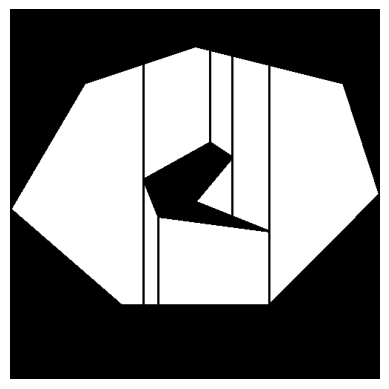

In [232]:
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

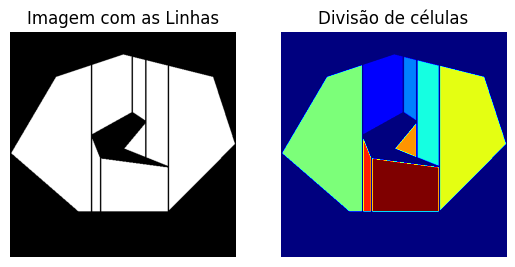

Number of cells found: 8


In [233]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
num_labels, labels_im = cv2.connectedComponents(binary)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Imagem com as Linhas')

plt.subplot(1, 2, 2)
plt.imshow(labels_im, cmap='jet')
plt.axis('off')
plt.title('Divisão de células')
plt.show()

print(f"Number of cells found: {num_labels - 1}")

Cluster 1 - ponto central (x, y): (223, 132)
Cluster 2 - ponto central (x, y): (285, 124)
Cluster 3 - ponto central (x, y): (325, 179)
Cluster 4 - ponto central (x, y): (115, 238)
Cluster 5 - ponto central (x, y): (407, 219)
Cluster 6 - ponto central (x, y): (283, 247)
Cluster 7 - ponto central (x, y): (189, 328)
Cluster 8 - ponto central (x, y): (272, 344)


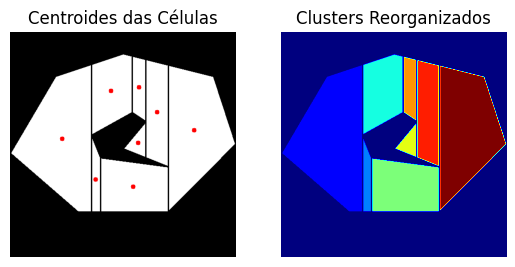

In [234]:
centroids = []
labels_im[labels_im == 0] = 0
num_labels = num_labels - 1

for cluster_index in range(1, num_labels + 1):
    cluster_mask = np.zeros_like(labels_im, dtype=np.uint8)
    cluster_mask[labels_im == cluster_index] = 255
    
    contours, _ = cv2.findContours(cluster_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
    center_x = int(np.mean(np.where(labels_im == cluster_index)[1]))
    center_y = int(np.mean(np.where(labels_im == cluster_index)[0]))
    centroids.append((cluster_index, (center_x, center_y)))

    print(f"Cluster {cluster_index} - ponto central (x, y): ({center_x}, {center_y})")

    cv2.circle(image, (center_x, center_y), 5, (0, 0, 255), -1)

centroids.sort(key=lambda x: x[1][0])

new_labels_im = np.zeros_like(labels_im)
for new_id, (old_id, centroid) in enumerate(centroids, start=1):
    new_labels_im[labels_im == old_id] = new_id

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Centroides das Células')

plt.subplot(1, 2, 2)
plt.imshow(new_labels_im, cmap='jet')
plt.axis('off')
plt.title('Clusters Reorganizados')
plt.show()

Células 1 e 2 são vizinhas. Distância mínima: 4.00
Células 1 e 3 são vizinhas. Distância mínima: 4.00
Células 1 e 4 não são vizinhas. Distância mínima: 24.00
Células 1 e 5 não são vizinhas. Distância mínima: 157.94
Células 1 e 6 não são vizinhas. Distância mínima: 94.15
Células 1 e 7 não são vizinhas. Distância mínima: 124.00
Células 1 e 8 não são vizinhas. Distância mínima: 174.00
Células 2 e 3 não são vizinhas. Distância mínima: 12.00
Células 2 e 4 são vizinhas. Distância mínima: 4.00
Células 2 e 5 não são vizinhas. Distância mínima: 58.52
Células 2 e 6 não são vizinhas. Distância mínima: 108.45
Células 2 e 7 não são vizinhas. Distância mínima: 104.00
Células 2 e 8 não são vizinhas. Distância mínima: 154.00
Células 3 e 4 não são vizinhas. Distância mínima: 58.52
Células 3 e 5 não são vizinhas. Distância mínima: 39.82
Células 3 e 6 são vizinhas. Distância mínima: 4.12
Células 3 e 7 não são vizinhas. Distância mínima: 35.00
Células 3 e 8 não são vizinhas. Distância mínima: 85.00
Célula

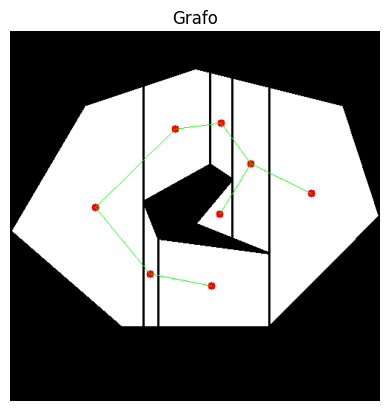

In [235]:
def min_distance_between_contours(contour1, contour2):
    min_dist = float('inf')
    for point in contour1:
        dist = cv2.pointPolygonTest(contour2, (int(point[0][0]), int(point[0][1])), True)
        if abs(dist) < min_dist:
            min_dist = abs(dist)
    return min_dist

def bresenham_line(pt1, pt2):
    """Algoritmo de Bresenham para calcular os pixels de uma linha."""
    x0 = pt1[0]
    y0 = pt1[1]

    x1 = pt2[0]
    y1 = pt2[1]

    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    
    return points

cell = {}
cells = []

distance_threshold = 4.15

contours_list = []
for i in range(1, num_labels + 1):
    cluster_mask = np.zeros_like(new_labels_im, dtype=np.uint8)
    cluster_mask[new_labels_im == i] = 255
    contours, _ = cv2.findContours(cluster_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
    if contours:
        contours_list.append(contours[0])

# Creating the cell

for i in range(len(contours_list)):
    neighbors = []
    collision_detected = False

    for j in range(i + 1, len(contours_list)):
        dist = min_distance_between_contours(contours_list[i], contours_list[j])

        if dist < distance_threshold:
            points = bresenham_line(centroids[i][1], centroids[j][1])
            for point in points:
                if (clear_img[point[1], point[0]].all() == 0):
                    print(f"Colisão entre células {i + 1} e {j + 1}. Aresta não será criada.")
                    collision_detected = True
                    break

            if collision_detected == False:
                print(f"Células {i + 1} e {j + 1} são vizinhas. Distância mínima: {dist:.2f}")
                neighbors.append(j + 1)
                cv2.line(image, centroids[i][1], centroids[j][1], color=(0,255,0), thickness=1)
            else:
                collision_detected = False
        else:
            print(f"Células {i + 1} e {j + 1} não são vizinhas. Distância mínima: {dist:.2f}")

    cell['id'] = i + 1
    cell['border_pixels'] = [[point[0], point[1]] for contour in contours_list[i] for point in contour]
    cell['center'] = centroids[i][1]
    cell['neighbors'] = neighbors
    cells.append(cell)
    cell = {}

image_with_contours = image.copy()
# cv2.drawContours(image_with_contours, contours_list[1], -1, (0, 255, 0), 5)
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Grafo')
plt.show()

### Busca no Grafo

Caminho de cobertura encontrado: [1, 2, 4, 2, 1, 3, 6, 7, 5, 7, 8]


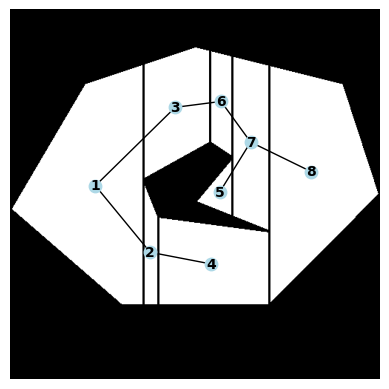

In [236]:
G = nx.Graph()

for cell in cells:
    G.add_node(cell['id'], center=cell['center'], border_pixels=cell['border_pixels'])

for cell in cells:
    for neighbor_id in cell['neighbors']:
        neighbor = next(c for c in cells if c['id'] == neighbor_id)
        G.add_edge(cell['id'], neighbor_id)

def dfs_cover_path(G, start):
    visited = set()
    path = []

    def dfs(node):
        path.append(node)
        visited.add(node)

        for neighbor in G.neighbors(node):
            if neighbor not in visited:
                dfs(neighbor)
                if set(G.nodes).issubset(path):
                    return
                path.append(node)

    dfs(start)
    return path

start_node = 1
cover_path = dfs_cover_path(G, start_node)
print("Caminho de cobertura encontrado:", cover_path)

pos = {cell['id']: cell['center'] for cell in cells}
plt.imshow(image_rgb)
nx.draw(G, pos, with_labels=True, node_size=80, node_color='lightblue', font_weight='bold', font_size='10')
plt.show()


### Navegação

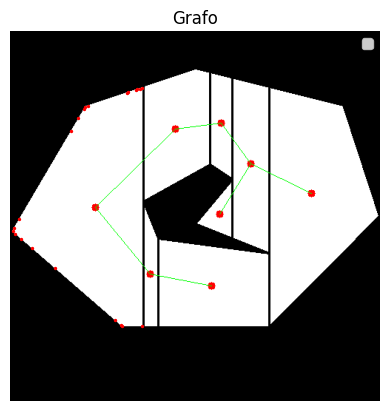

[INFO] [1721519570.443651]: Going to cell center...
[INFO] [1721519571.470993]: Going to cell center...
[INFO] [1721519572.499211]: Going to cell center...
[INFO] [1721519573.527550]: Going to cell center...
Vetor modificado: [[128.07453801500876, 109.77608408774333], [171.47180311654762, 109.77608408774333], [171.4676389338843, 126.77608408774333], [99.8227593240293, 126.77608408774333], [90.99132542469422, 143.77608408774333], [171.46347475122099, 143.77608408774333], [171.45931056855767, 160.77608408774333], [81.85842891221212, 160.77608408774333], [71.98686523151726, 177.77608408774333], [171.45514638589435, 177.77608408774333], [171.45098220323104, 194.77608408774333], [62.1153015508224, 194.77608408774333], [52.243737870127546, 211.77608408774333], [171.44681802056775, 211.77608408774333], [171.44265383790443, 228.77608408774333], [42.37217418943269, 228.77608408774333], [32.500610508737836, 245.77608408774333], [171.4384896552411, 245.77608408774333], [171.4343254725778, 262.776

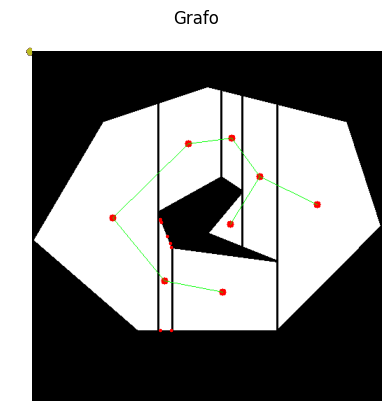

[INFO] [1721520028.613868]: Going to cell center...
[INFO] [1721520029.639008]: Going to cell center...
[INFO] [1721520030.663512]: Going to cell center...
[INFO] [1721520031.688383]: Going to cell center...
[INFO] [1721520032.711790]: Going to cell center...
[INFO] [1721520033.736425]: Going to cell center...
[INFO] [1721520034.759367]: Going to cell center...
[INFO] [1721520035.784770]: Going to cell center...
[INFO] [1721520036.807863]: Going to cell center...
[INFO] [1721520037.832295]: Going to cell center...
[INFO] [1721520038.857156]: Going to cell center...
[INFO] [1721520039.881012]: Going to cell center...
[INFO] [1721520040.904668]: Going to cell center...
[INFO] [1721520041.932182]: Going to cell center...
[INFO] [1721520042.954451]: Going to cell center...
Vetor modificado: [[183.46378816207059, 273.94458219388025], [188.71273471251058, 273.94458219388025], [193.45388878015416, 290.94458219388025], [183.5162046909146, 290.94458219388025], [183.56862121975865, 307.944582193

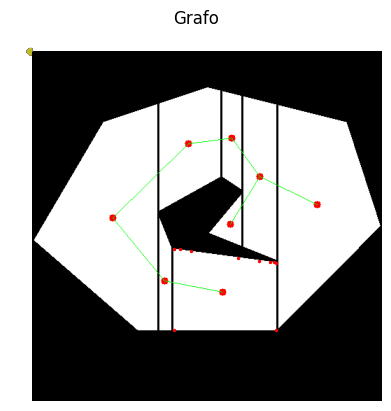

[INFO] [1721520084.818286]: Going to cell center...
[INFO] [1721520085.841592]: Going to cell center...
[INFO] [1721520086.866214]: Going to cell center...
[INFO] [1721520087.891723]: Going to cell center...
[INFO] [1721520088.915633]: Going to cell center...
[INFO] [1721520089.942479]: Going to cell center...
[INFO] [1721520090.967188]: Going to cell center...
[INFO] [1721520091.993384]: Going to cell center...
[INFO] [1721520093.019176]: Going to cell center...
[INFO] [1721520094.044846]: Going to cell center...
[INFO] [1721520095.071491]: Going to cell center...
[INFO] [1721520096.097557]: Going to cell center...
[INFO] [1721520097.121967]: Going to cell center...
[INFO] [1721520098.149614]: Going to cell center...
[INFO] [1721520099.174864]: Going to cell center...
[INFO] [1721520100.200204]: Going to cell center...
[INFO] [1721520101.224202]: Going to cell center...
[INFO] [1721520102.249771]: Going to cell center...
[INFO] [1721520103.274341]: Going to cell center...
[INFO] [1721

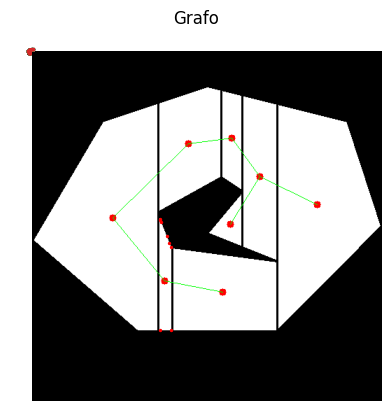

[INFO] [1721520271.129394]: Going to cell center...
[INFO] [1721520272.153288]: Going to cell center...
[INFO] [1721520273.176279]: Going to cell center...
[INFO] [1721520274.199837]: Going to cell center...
[INFO] [1721520275.225482]: Going to cell center...
[INFO] [1721520276.250627]: Going to cell center...
[INFO] [1721520277.276634]: Going to cell center...
[INFO] [1721520278.300038]: Going to cell center...
[INFO] [1721520279.324444]: Going to cell center...
[INFO] [1721520280.349529]: Going to cell center...
[INFO] [1721520281.374403]: Going to cell center...
[INFO] [1721520282.398756]: Going to cell center...
[INFO] [1721520283.422107]: Going to cell center...
[INFO] [1721520284.445957]: Going to cell center...
[INFO] [1721520285.469229]: Going to cell center...
[INFO] [1721520286.493815]: Going to cell center...
[INFO] [1721520287.517993]: Going to cell center...
[INFO] [1721520288.542673]: Going to cell center...
[INFO] [1721520289.566507]: Going to cell center...
[INFO] [1721

[WARN] [1721520303.500060]: Célula já coberta.


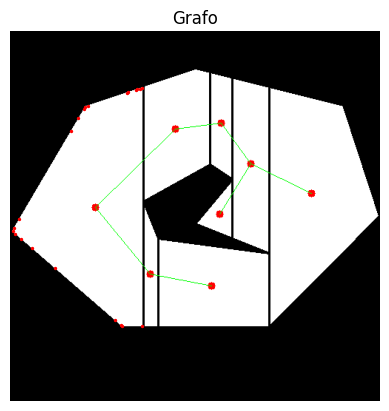

[INFO] [1721520303.976217]: Going to cell center...
[INFO] [1721520305.000844]: Going to cell center...
[INFO] [1721520306.027138]: Going to cell center...
[INFO] [1721520307.050781]: Going to cell center...
[INFO] [1721520308.074562]: Going to cell center...
[INFO] [1721520309.099333]: Going to cell center...
[INFO] [1721520310.122969]: Going to cell center...
[INFO] [1721520311.147588]: Going to cell center...
[INFO] [1721520312.171635]: Going to cell center...
[INFO] [1721520313.196331]: Going to cell center...
[INFO] [1721520314.220744]: Going to cell center...
[INFO] [1721520315.246818]: Going to cell center...
[INFO] [1721520316.273100]: Going to cell center...
[INFO] [1721520317.296586]: Going to cell center...
[INFO] [1721520318.320613]: Going to cell center...
[INFO] [1721520319.345617]: Going to cell center...
[INFO] [1721520320.369725]: Going to cell center...
[INFO] [1721520321.393442]: Going to cell center...
[INFO] [1721520322.419870]: Going to cell center...
[INFO] [1721

[WARN] [1721520328.056411]: Célula já coberta.


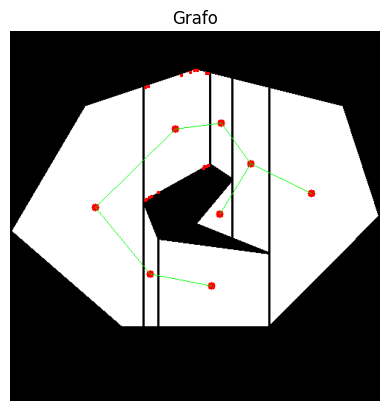

[INFO] [1721520328.632188]: Going to cell center...
[INFO] [1721520329.656126]: Going to cell center...
[INFO] [1721520330.681334]: Going to cell center...
[INFO] [1721520331.706544]: Going to cell center...
[INFO] [1721520332.735096]: Going to cell center...
[INFO] [1721520333.760008]: Going to cell center...
[INFO] [1721520334.784195]: Going to cell center...
[INFO] [1721520335.808244]: Going to cell center...
[INFO] [1721520336.831346]: Going to cell center...
[INFO] [1721520337.854833]: Going to cell center...
[INFO] [1721520338.878895]: Going to cell center...
[INFO] [1721520339.904144]: Going to cell center...
[INFO] [1721520340.929926]: Going to cell center...
[INFO] [1721520341.955044]: Going to cell center...
[INFO] [1721520342.979972]: Going to cell center...
[INFO] [1721520344.004625]: Going to cell center...
[INFO] [1721520345.030324]: Going to cell center...
[INFO] [1721520346.055018]: Going to cell center...
[INFO] [1721520347.080581]: Going to cell center...
[INFO] [1721

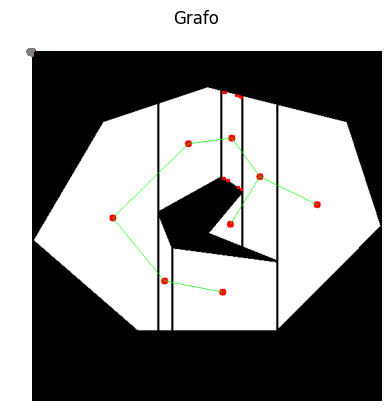

[INFO] [1721520509.027606]: Going to cell center...
[INFO] [1721520510.052382]: Going to cell center...
[INFO] [1721520511.077340]: Going to cell center...
[INFO] [1721520512.100843]: Going to cell center...
[INFO] [1721520513.126843]: Going to cell center...
[INFO] [1721520514.151773]: Going to cell center...
[INFO] [1721520515.175465]: Going to cell center...
[INFO] [1721520516.199672]: Going to cell center...
[INFO] [1721520517.222003]: Going to cell center...
[INFO] [1721520518.247626]: Going to cell center...
[INFO] [1721520519.271427]: Going to cell center...
[INFO] [1721520520.295638]: Going to cell center...
[INFO] [1721520521.320105]: Going to cell center...
[INFO] [1721520522.344132]: Going to cell center...
[INFO] [1721520523.369555]: Going to cell center...
[INFO] [1721520524.393447]: Going to cell center...
[INFO] [1721520525.419366]: Going to cell center...
[INFO] [1721520526.444372]: Going to cell center...
[INFO] [1721520527.469009]: Going to cell center...
[INFO] [1721

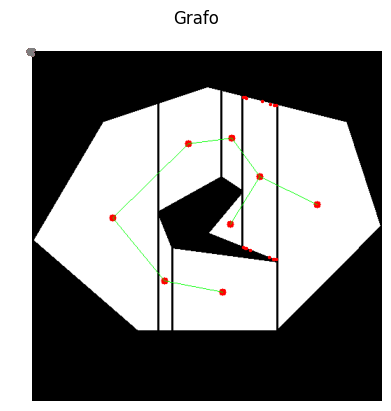

[INFO] [1721520588.687165]: Going to cell center...
[INFO] [1721520589.711357]: Going to cell center...
[INFO] [1721520590.739281]: Going to cell center...
[INFO] [1721520591.763793]: Going to cell center...
[INFO] [1721520592.787916]: Going to cell center...
[INFO] [1721520593.812976]: Going to cell center...
[INFO] [1721520594.838059]: Going to cell center...
Vetor modificado: [[305.6049906071319, 99.64447413930195], [344.09286936966953, 99.64447413930195], [344.13671679175343, 116.64447413930195], [305.6501311686152, 116.64447413930195], [305.69527173009845, 133.64447413930196], [344.1805642138374, 133.64447413930196], [344.2244116359213, 150.64447413930196], [305.7404122915817, 150.64447413930196], [305.785552853065, 167.64447413930196], [344.2682590580052, 167.64447413930196], [344.31210648008914, 184.64447413930196], [305.83069341454825, 184.64447413930196], [305.8758339760315, 201.64447413930196], [344.35595390217304, 201.64447413930196], [344.399801324257, 218.64447413930196], 

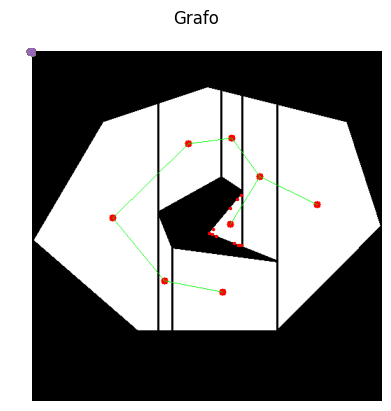

[INFO] [1721520760.215081]: Going to cell center...
[INFO] [1721520761.239753]: Going to cell center...
[INFO] [1721520762.263197]: Going to cell center...
[INFO] [1721520763.286989]: Going to cell center...
[INFO] [1721520764.311535]: Going to cell center...
[INFO] [1721520765.335365]: Going to cell center...
[INFO] [1721520766.360877]: Going to cell center...
[INFO] [1721520767.384090]: Going to cell center...
[INFO] [1721520768.407610]: Going to cell center...
[INFO] [1721520769.431758]: Going to cell center...
[INFO] [1721520770.455503]: Going to cell center...
[INFO] [1721520771.480036]: Going to cell center...
[INFO] [1721520772.504978]: Going to cell center...
[INFO] [1721520773.528574]: Going to cell center...
[INFO] [1721520774.552357]: Going to cell center...
Vetor modificado: [[283.8388395942146, 238.95135440870706], [291.0748451868684, 238.95135440870706], [290.2037455197036, 255.95135440870706], [284.1293983640268, 255.95135440870706]]
[INFO] [1721520775.014724]: Cell 5 - 

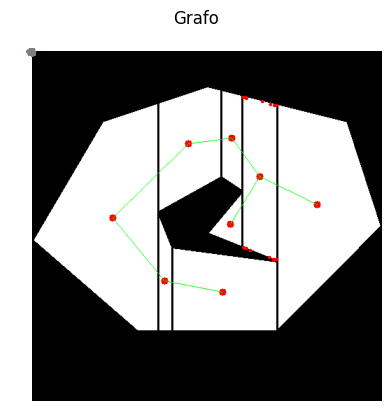

[INFO] [1721520779.000155]: Going to cell center...
[INFO] [1721520780.025044]: Going to cell center...
[INFO] [1721520781.050157]: Going to cell center...
[INFO] [1721520782.074992]: Going to cell center...
[INFO] [1721520783.098651]: Going to cell center...
[INFO] [1721520784.123437]: Going to cell center...
[INFO] [1721520785.148051]: Going to cell center...
[INFO] [1721520786.171467]: Going to cell center...
[INFO] [1721520787.199061]: Going to cell center...
[INFO] [1721520788.222092]: Going to cell center...
[INFO] [1721520789.246068]: Going to cell center...
[INFO] [1721520790.269739]: Going to cell center...
[INFO] [1721520791.294090]: Going to cell center...
[INFO] [1721520792.319772]: Going to cell center...
[INFO] [1721520793.342723]: Going to cell center...
[INFO] [1721520794.367522]: Going to cell center...
[INFO] [1721520795.391298]: Going to cell center...
[INFO] [1721520796.415272]: Going to cell center...
[INFO] [1721520797.439116]: Going to cell center...
[INFO] [1721

[WARN] [1721520804.306402]: Célula já coberta.


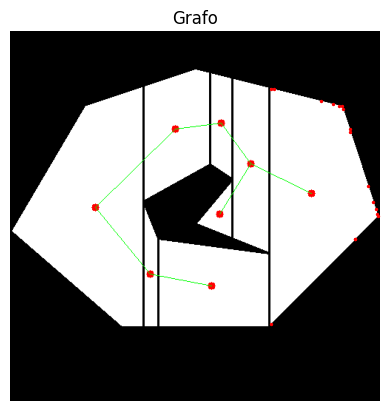

[INFO] [1721520804.680754]: Going to cell center...
[INFO] [1721520805.705035]: Going to cell center...
[INFO] [1721520806.732229]: Going to cell center...
[INFO] [1721520807.756366]: Going to cell center...
[INFO] [1721520808.779868]: Going to cell center...
[INFO] [1721520809.805010]: Going to cell center...
[INFO] [1721520810.829248]: Going to cell center...
[INFO] [1721520811.853209]: Going to cell center...
[INFO] [1721520812.879621]: Going to cell center...
[INFO] [1721520813.904043]: Going to cell center...
[INFO] [1721520814.931111]: Going to cell center...
[INFO] [1721520815.956851]: Going to cell center...
[INFO] [1721520816.981279]: Going to cell center...
[INFO] [1721520818.006446]: Going to cell center...
[INFO] [1721520819.034432]: Going to cell center...
[INFO] [1721520820.063589]: Going to cell center...
[INFO] [1721520821.089535]: Going to cell center...
[INFO] [1721520822.120979]: Going to cell center...
[INFO] [1721520823.153081]: Going to cell center...
[INFO] [1721

In [237]:
import math
import rospy
import numpy as np
from geometry_msgs.msg import PoseStamped
from sensor_msgs.msg import LaserScan
import tf2_ros as tf
from tf.transformations import euler_from_quaternion
from LinearizationController import LinearizationController
import matplotlib.pyplot as plt
from std_msgs.msg import Bool
from shapely.geometry import Polygon, LineString, MultiLineString

class Coverage:
    def __init__(self):
        rospy.init_node('coverage_node', anonymous=False)

        self.pose = np.array([])
        self.obstacles_indexes = []
        self.laser_readings = LaserScan()
        self.transform = np.array([])
        self.angles = np.linspace(-120*math.pi/180, 120*math.pi/180, num=684)
        self.transform = np.array([])

        # Subscribers
        self.pose_sub = rospy.Subscriber('/pose', PoseStamped, self.pose_callback)
        self.laser_sub = rospy.Subscriber('/scan', LaserScan, self.laser_callback)

    def get_transformation_matrix(self, pose):
        cos_theta = np.cos(pose[2])
        sin_theta = np.sin(pose[2])
    
        R = np.array([[cos_theta, -sin_theta],
                  [sin_theta, cos_theta]])
    
        P = np.array([[pose[0]],
                    [pose[1]]])
    
        T = np.block([[R, P],
                    [0, 0, 1]])
        return T

    def laser_callback(self, readings):
        self.laser_readings = readings
        range_tol = readings.range_max - 0.01

        indexes = []
        init = None
        end = 0

        for i in range(684):
            if (self.laser_readings.ranges[i] < range_tol and init is None):
                init = i
            if (self.laser_readings.ranges[i] >= range_tol and init is not None):
                end = i - 1
                indexes.append([init, end])
                init = None
            elif (i == 683 and init is not None):
                end = i
                indexes.append([init, end])
                init = None

        self.obstacles_indexes = indexes

    def pose_callback(self, pose):
        x = pose.pose.position.x
        y = pose.pose.position.y
        
        q_x = pose.pose.orientation.x
        q_y = pose.pose.orientation.y
        q_z = pose.pose.orientation.z
        q_w = pose.pose.orientation.w

        yaw = euler_from_quaternion([q_x, q_y, q_z, q_w])[2]
        self.pose = np.array([x, y, yaw])

        self.transform = self.get_transformation_matrix(self.pose)

    def get_transform_matrix(self):
        cos_theta = np.cos(np.pi)
        sin_theta = np.sin(np.pi)
        
        pos=[-250, 250, 1]

        R = np.array([[1, 0, 0],
                    [0, cos_theta, -sin_theta],
                    [0, sin_theta, cos_theta]])

        P = np.array([[pos[0]],
                    [pos[1]],
                    [pos[2]]])

        T = np.block([[R, P],
                    [0, 0, 0, 1]])
        
        return T

    def get_grad(self, obstacles_coords, goal):
        # Function parameters
        d_star = 1.0
        zeta = 10
        d_o = 0.2
        eta = 10
        grad_rep = np.array([0.0, 0.0])

        q = np.array([self.pose[0], self.pose[1]])
        q_goal = np.array([goal[0], goal[1]])

        d = q - q_goal
        d_norm = np.linalg.norm(d)
        if d_norm <= d_star:
            grad_att = zeta * d
        else:
            grad_att = d_star * zeta * d / d_norm

        for coord in obstacles_coords:
            q_obs = np.array([coord[0], coord[1]])
            d_obs = q - q_obs
            d_norm = np.linalg.norm(d_obs)

            grad_d_obs = d_obs / d_norm
            
            if d_norm <= d_o:
                grad_rep = grad_rep + eta * (1 / d_o - 1 / d_norm) * grad_d_obs / (d_norm)**2

        grad_d_obs = - (grad_att + grad_rep)
        return grad_d_obs
    
    def get_obstacles(self, indexes, readings):
        if (rospy.wait_for_message('/scan', LaserScan)):
            ranges = readings.ranges
            obstacles_positions = []

            T = self.transform

            # Positions referenced to the robot
            if len(indexes) > 0:

                for i in range(len(indexes)):
                    start = indexes[i][0]
                    end = indexes[i][1]
                    interval = list(range(start, end))

                    values = np.array(ranges)[interval]

                    if (values.any()):
                        local_index = np.argmin(values)
                        min_index = interval[local_index]

                        x = ranges[min_index] * math.cos(min_index)
                        y = ranges[min_index] * math.sin(min_index)

                        vec = np.array([x, y, 1])

                        # Positions referenced to the global frame
                        global_vec = np.dot(T, vec)[:2]
                        obstacles_positions.append(global_vec)

            else:
                return np.array([0.0, 0.0])

            return np.asarray(obstacles_positions)

    def get_position_meters(self, pixel):
        T = self.get_transform_matrix()
        vec = np.dot(T, np.array([pixel[0], pixel[1], 1, 1]))[:2]

        point_x = vec[0] * (15 / 500)
        point_y = vec[1] * (15 / 500)

        return [point_x, point_y] 

    def get_cell_safe_border(self, vertices, centroid):
        L = 18 # pixels
        safe_points = []

        for vertex in vertices:
            c = np.array([centroid[0], centroid[1]])
            q = np.array([vertex[0], vertex[1]])

            d = np.linalg.norm(c - q)

            x_goal = vertex[0] + L * (centroid[0] - vertex[0]) / d
            y_goal = vertex[1] + L * (centroid[1] - vertex[1]) / d

            safe_points.append([x_goal, y_goal])
        return safe_points

    """Funções de geração das linhas de cobertura"""
    def get_extreme_points(self, vertices):
        x_coords, y_coords = zip(*vertices)
        
        left_point = (min(x_coords), y_coords[x_coords.index(min(x_coords))])
        right_point = (max(x_coords), y_coords[x_coords.index(max(x_coords))])
        bottom_point = (x_coords[y_coords.index(min(y_coords))], min(y_coords))
        top_point = (x_coords[y_coords.index(max(y_coords))], max(y_coords))
        
        return {
            "left": left_point,
            "right": right_point,
            "bottom": bottom_point,
            "top": top_point
        }

    def get_lines(self, vertices, spacing):
        polygon = Polygon(vertices)
        extreme_points = self.get_extreme_points(vertices)
        
        min_x = extreme_points["left"][0]
        max_x = extreme_points["right"][0]
        min_y = extreme_points["bottom"][1]
        max_y = extreme_points["top"][1]
        
        lines = []

        # Gera lines de varredura paralelas ao eixo y
        y = min_y
        while y <= max_y:
            line = LineString([(min_x, y), (max_x, y)])
            intersections = polygon.intersection(line)
            
            # Verifica se há interseções e adiciona ao resultado
            if isinstance(intersections, LineString):
                if len(intersections.coords) > 1:  # Verifica se a linha é longa o suficiente
                    lines.append(list(intersections.coords))
            elif isinstance(intersections, MultiLineString):

                mls_list = list(intersections.geoms)
                segment = mls_list[0]
                if isinstance(segment, LineString):
                    if len(segment.coords) > 1:
                        lines.append(list(segment.coords))
            
            y += spacing    
        return lines

    def run(self):
        try:
            controller = LinearizationController()
            rate = rospy.Rate(10)

            rospy.wait_for_message('/scan', LaserScan)
            rospy.wait_for_message('/pose', PoseStamped)

            covered = []

            plt.figure()
            plt.imshow(clear_img)
            plt.legend()
            positions = []

            """Cobertura das células"""
            for cell_id in cover_path:
                cell = next((c for c in cells if c['id'] == cell_id), None)

                vertices = cell['border_pixels']
                centroid = cell['center']

                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.scatter([v[0] for v in vertices], [v[1] for v in vertices], s=2, c='r')
                plt.axis('off')
                plt.title('Grafo')
                plt.show()

                # Go to cell center first
                center = self.get_position_meters(centroid)
                center_x = center[0]
                center_y = center[1]

                while not controller.is_goal_reached(center_x, center_y):
                        q = np.array([self.pose[0], self.pose[1]])
                        positions.append(q)
                        controller.go_to_goal(center_x, center_y, 1.0, 1.0)
                        rospy.sleep(0.1)

                        rospy.loginfo_throttle(2, "Going to cell center...")

                if cell_id not in covered:
                    safe_border = self.get_cell_safe_border(vertices, centroid)
                    lines = self.get_lines(safe_border, 17)

                    points = [[point[0], point[1]] for line in lines if line for point in line]

                    new_points = []
                    for i in range(0, len(points), 4):
                        if i + 1 < len(points):
                            new_points.append(points[i])
                            new_points.append(points[i + 1])
                        if i + 3 < len(points):
                            new_points.append(points[i + 3])
                            new_points.append(points[i + 2])
                        elif i + 2 < len(points):
                            new_points.append(points[i + 2])

                    print("Vetor modificado:", new_points)
        
                    for point in new_points:
                        goal = self.get_position_meters(point)
                        x_goal = goal[0]
                        y_goal = goal[1]

                        while not controller.is_goal_reached(x_goal, y_goal):

                            obstacles = self.get_obstacles(self.obstacles_indexes,
                                                            self.laser_readings)

                            q = np.array([self.pose[0], self.pose[1]])
                            positions.append(q)

                            grad = self.get_grad(obstacles, [x_goal, y_goal])
                            controller.go_to_goal(x_goal, y_goal, grad[0], grad[1])
                            
                            rospy.sleep(0.1)
                            rospy.loginfo_throttle(2, "Cell %d - Going to goal: %f, %f" % (cell_id, x_goal, y_goal))

                            plt.plot([pos[0] for pos in positions], [pos[1] for pos in positions], label='Trajetória do robô')       
                            plt.savefig("trajectory.png")

                        f = open("cells.txt", "w")

                        for pos in positions:
                            f.write("%f %f\n" % (pos[0], pos[1]))
                        f.close()

                    while not controller.is_goal_reached(center_x, center_y):
                        q = np.array([self.pose[0], self.pose[1]])
                        positions.append(q)
                        controller.go_to_goal(center_x, center_y, 1.0, 1.0)
                        rospy.sleep(0.1)

                        rospy.loginfo_throttle(2, "Returning to cell center...")

                    # Registrando as células percorridas
                    covered.append(cell_id)    

                else:
                    rospy.logwarn("Célula já coberta.")

            controller.stop_robot()
            rospy.sleep(2)
            plt.close()

        except KeyboardInterrupt:
            return

if __name__ == "__main__":
    cov = Coverage()
    cov.run()